In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

## Load data

In [3]:
path = 'yelp_data/health_text_sentiment.csv'
df = pd.read_csv(path)
df.drop(['Unnamed: 0'],axis=1,inplace=True)

data = df[['stars','text','clean_text']]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64006 entries, 0 to 64005
Data columns (total 3 columns):
stars         64006 non-null int64
text          64006 non-null object
clean_text    64006 non-null object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [5]:
data.stars.value_counts()

5    31726
1    21988
4     4245
2     3761
3     2286
Name: stars, dtype: int64

## Select 1 & 5 stars only

In [6]:
data = data.ix[np.where((data.stars==1)|(data.stars==5))]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53714 entries, 0 to 64005
Data columns (total 3 columns):
stars         53714 non-null int64
text          53714 non-null object
clean_text    53714 non-null object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


# Multinimial NB

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,recall_score,precision_score

## split data into test train

In [8]:
review = data['text'].values.astype(str)  # original review
review_clean = data['clean_text'].values.astype(str)  # clean text review
sentiments = data['stars'].values  # star value

X_train, X_test, y_train, y_test = train_test_split(review, sentiments, test_size=0.33, random_state=42)

### CountVectorizer

In [9]:
# initializing a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words='english')  # count the number of words in the document
count_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test)

## Classifier

In [10]:
classifier = MultinomialNB()
classifier.fit(count_train, y_train)  # we fit with the X_train_vectorized, not original X_train

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Predict

In [11]:
pred_count_vect = classifier.predict(count_test)

## Accuracy

In [12]:
# Calculate the accuracy score: score
score_cv = metrics.accuracy_score(y_test,pred_count_vect)
print(score_cv)

0.9562224980254993


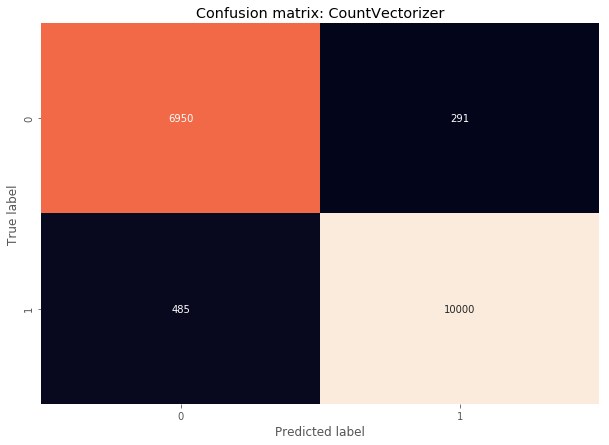

In [13]:
cm = confusion_matrix(y_test, pred_count_vect)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.title('Confusion matrix: CountVectorizer')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [14]:
print(classification_report(y_test, pred_count_vect))

              precision    recall  f1-score   support

           1       0.93      0.96      0.95      7241
           5       0.97      0.95      0.96     10485

   micro avg       0.96      0.96      0.96     17726
   macro avg       0.95      0.96      0.95     17726
weighted avg       0.96      0.96      0.96     17726



## TFIDF

In [15]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english',max_df=0.7)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

## Classifier

In [16]:
# Create a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(tfidf_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Predict

In [17]:
# Create the predicted tags: pred
pred_tfidf = nb_classifier.predict(tfidf_test)

## Accuracy

In [18]:
# Calculate the accuracy score: score
score_tf = metrics.accuracy_score(y_test,pred_tfidf)
print(score_tf)

0.9552634548121404


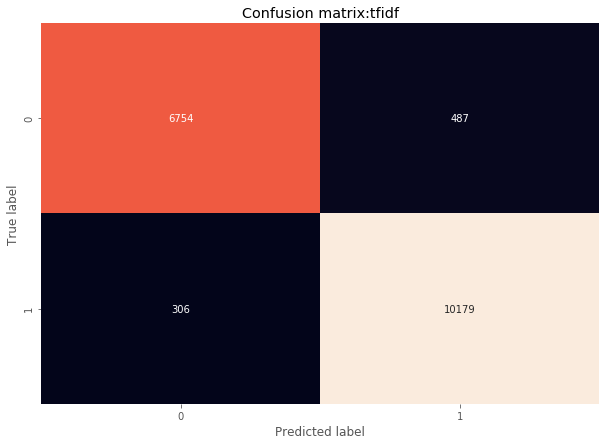

In [19]:
cm = confusion_matrix(y_test, pred_tfidf)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.title('Confusion matrix:tfidf')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [20]:
print(classification_report(y_test, pred_tfidf))

              precision    recall  f1-score   support

           1       0.96      0.93      0.94      7241
           5       0.95      0.97      0.96     10485

   micro avg       0.96      0.96      0.96     17726
   macro avg       0.96      0.95      0.95     17726
weighted avg       0.96      0.96      0.96     17726



## alpha values

In [21]:
# Create the list of alphas: alphas
alphas = np.arange(0,1.1,0.1)

def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    # Fit to the training data
    nb_classifier.fit(tfidf_train,y_train)
    # Predict the labels: pred
    pred = nb_classifier.predict(tfidf_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test,pred)
    return score

In [22]:
alpha_results = {}
for alpha in alphas:
    if alpha in alpha_results:
        alpha_results[alpha].append(train_and_predict(alpha))
    else:
        alpha_results[alpha] = train_and_predict(alpha)

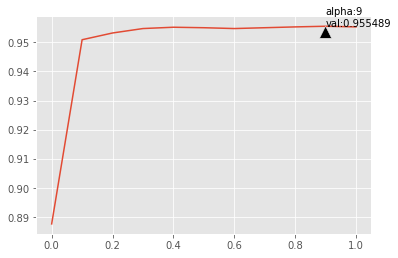

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)

x=list(alpha_results.keys())
y=list(alpha_results.values())
line, = ax.plot(x, y)

ymax = max(y)
xpos = y.index(ymax)
xmax = x[xpos]
value = 'alpha:{}\nval:{:3f}'.format(xpos,ymax)
ax.annotate(value, xy=(xmax, ymax),
            arrowprops=dict(facecolor='black'),
            )
plt.show()

## change alpha values

In [24]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english',max_df=0.7)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

## Classifier

In [25]:
# Create a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB(alpha=0.9)

# Fit the classifier to the training data
nb_classifier.fit(tfidf_train,y_train)

MultinomialNB(alpha=0.9, class_prior=None, fit_prior=True)

## Predict

In [26]:
# Create the predicted tags: pred
pred_tfidf = nb_classifier.predict(tfidf_test)

## Accuracy

In [27]:
# Calculate the accuracy score: score
score_tfidf_alpha_change= metrics.accuracy_score(y_test,pred_tfidf)
print(score_tfidf_alpha_change)

0.955489112038813


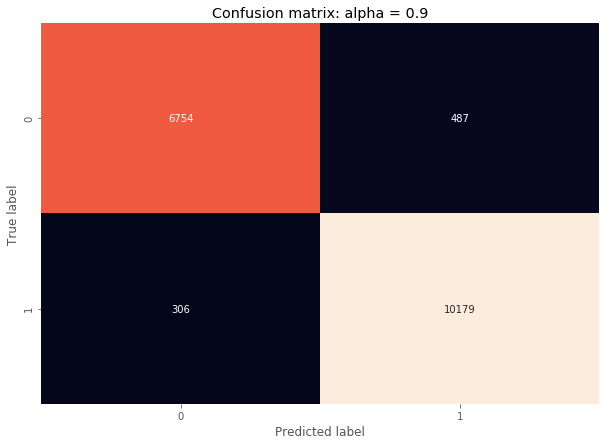

In [28]:
cm_alpha_change = confusion_matrix(y_test, pred_tfidf)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.title('Confusion matrix: alpha = 0.9')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Alpha change results

In [31]:
print('alpha = 1   : \t{:3f}\nalpha = 0.9 : \t{:3f}'.format(score_tf,score_tfidf_alpha_change))

alpha = 1   : 	0.955263
alpha = 0.9 : 	0.955489


## Final results

In [69]:
d = dict(((k, eval(k)) for k in ('score_cv', 'score_tf','score_tfidf_alpha_change')))

In [70]:
for x,y in d.items():
    print('{} : {:3f}'.format(x,y))
max_key = max(d, key=d.get)
max_val = max(d.values())

print('-----------------------------')
print('best value:  {} :\t{:3f}'.format(max_key,max_val))

score_cv : 0.956222
score_tf : 0.955263
score_tfidf_alpha_change : 0.955489
-----------------------------
best value:  score_cv :	0.956222


# All stars

In [72]:
df_all = df[['stars','text','clean_text']]
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64006 entries, 0 to 64005
Data columns (total 3 columns):
stars         64006 non-null int64
text          64006 non-null object
clean_text    64006 non-null object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


## Split data into test train

In [73]:
review = df_all['text'].values.astype(str)  # original review
review_clean = df_all['clean_text'].values.astype(str)  # clean text review
sentiments = df_all['stars'].values  # star value

X_train, X_test, y_train, y_test = train_test_split(review, sentiments, test_size=0.33, random_state=42)

## CountVectorizer

In [74]:
# initializing a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words='english')  # count the number of words in the document
count_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test)

## Classifier

In [75]:
classifier = MultinomialNB()
classifier.fit(count_train, y_train)  # we fit with the X_train_vectorized, not original X_train

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Predict

In [76]:
pred_count_vect = classifier.predict(count_test)

## Accuracy

In [77]:
# Calculate the accuracy score: score
score_cv = metrics.accuracy_score(y_test,pred_count_vect)
print(score_cv)

0.7991194015718208


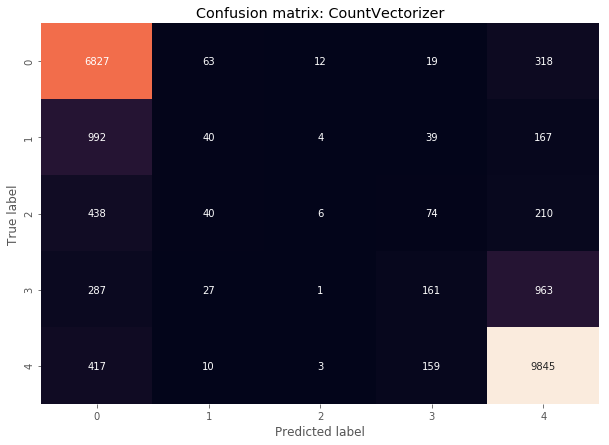

In [78]:
cm = confusion_matrix(y_test, pred_count_vect)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.title('Confusion matrix: CountVectorizer')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [79]:
print(classification_report(y_test, pred_count_vect))

              precision    recall  f1-score   support

           1       0.76      0.94      0.84      7239
           2       0.22      0.03      0.06      1242
           3       0.23      0.01      0.02       768
           4       0.36      0.11      0.17      1439
           5       0.86      0.94      0.90     10434

   micro avg       0.80      0.80      0.80     21122
   macro avg       0.49      0.41      0.40     21122
weighted avg       0.73      0.80      0.75     21122



## TFIDF

In [80]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english',max_df=0.7)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

## Classifier

In [81]:
# Create a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(tfidf_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Predict

In [82]:
# Create the predicted tags: pred
pred_tfidf = nb_classifier.predict(tfidf_test)

## Accuracy

In [83]:
# Calculate the accuracy score: score
score_tf = metrics.accuracy_score(y_test,pred_tfidf)
print(score_tf)

0.7976990815263706


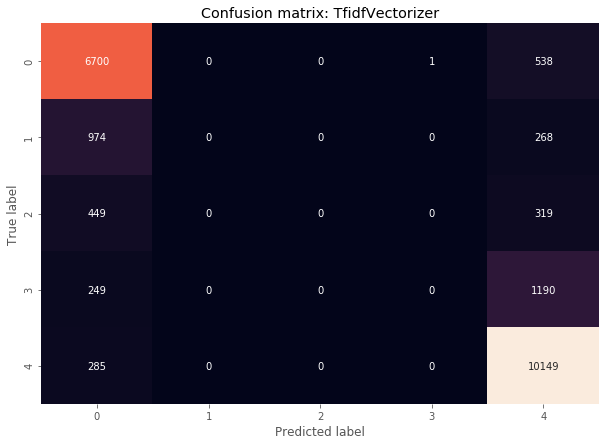

In [84]:
cm = confusion_matrix(y_test, pred_tfidf)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.title('Confusion matrix: TfidfVectorizer')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [85]:
print(classification_report(y_test, pred_count_vect))

              precision    recall  f1-score   support

           1       0.76      0.94      0.84      7239
           2       0.22      0.03      0.06      1242
           3       0.23      0.01      0.02       768
           4       0.36      0.11      0.17      1439
           5       0.86      0.94      0.90     10434

   micro avg       0.80      0.80      0.80     21122
   macro avg       0.49      0.41      0.40     21122
weighted avg       0.73      0.80      0.75     21122



## alpha values

In [86]:
alpha_results = {}
for alpha in alphas:
    if alpha in alpha_results:
        alpha_results[alpha].append(train_and_predict(alpha))
    else:
        alpha_results[alpha] = train_and_predict(alpha)

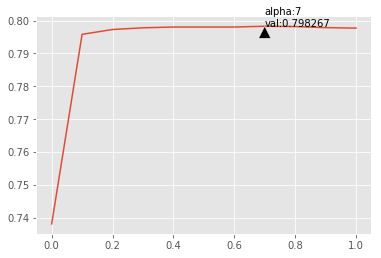

In [87]:
fig = plt.figure()
ax = fig.add_subplot(111)

x=list(alpha_results.keys())
y=list(alpha_results.values())
line, = ax.plot(x, y)

ymax = max(y)
xpos = y.index(ymax)
xmax = x[xpos]
value = 'alpha:{}\nval:{:3f}'.format(xpos,ymax)
ax.annotate(value, xy=(xmax, ymax),
            arrowprops=dict(facecolor='black'),
            )
plt.show()

## Change alpha values

In [88]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english',max_df=0.7)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

## Classifier

In [89]:
# Create a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB(alpha=0.7)

# Fit the classifier to the training data
nb_classifier.fit(tfidf_train,y_train)

MultinomialNB(alpha=0.7, class_prior=None, fit_prior=True)

## Predict

In [90]:
# Create the predicted tags: pred
pred_tfidf = nb_classifier.predict(tfidf_test)

## Accuracy

In [98]:
# Calculate the accuracy score: score
score_alpha_change = metrics.accuracy_score(y_test,pred_count_vect)
print(score_alpha_change)

0.7991194015718208


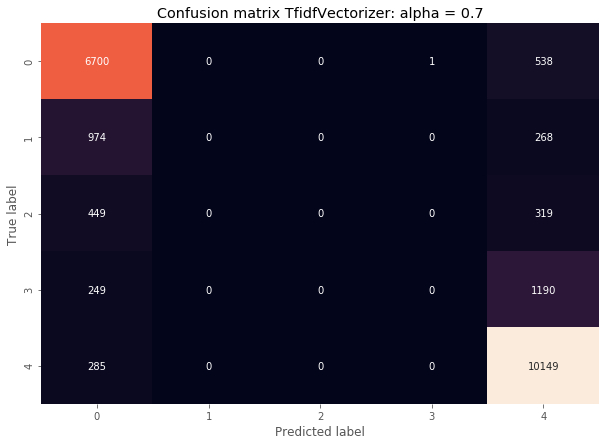

In [93]:
cm_alpha_change = confusion_matrix(y_test, pred_tfidf)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.title('Confusion matrix TfidfVectorizer: alpha = 0.7')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [94]:
print(classification_report(y_test, pred_count_vect))

              precision    recall  f1-score   support

           1       0.76      0.94      0.84      7239
           2       0.22      0.03      0.06      1242
           3       0.23      0.01      0.02       768
           4       0.36      0.11      0.17      1439
           5       0.86      0.94      0.90     10434

   micro avg       0.80      0.80      0.80     21122
   macro avg       0.49      0.41      0.40     21122
weighted avg       0.73      0.80      0.75     21122



# Alpha change results

In [95]:
print('alpha = 1   : \t{:3f}\nalpha = 0.7 : \t{:3f}'.format(score_tf,score_alpha_change))

alpha = 1   : 	0.797699
alpha = 0.7 : 	0.799119


## Result

In [99]:
d = dict(((k, eval(k)) for k in ('score_cv', 'score_tf','score_alpha_change')))


for x,y in d.items():
    print('{} : {:3f}'.format(x,y))
max_key = max(d, key=d.get)
max_val = max(d.values())

print('-----------------------------')
print('best value:  {} :\t{:3f}'.format(max_key,max_val))

score_cv : 0.799119
score_tf : 0.797699
score_alpha_change : 0.799119
-----------------------------
best value:  score_cv :	0.799119
